# [“Learning From Protein Structure with Geometric Vector Perceptrons”](https://openreview.net/pdf?id=1YLJDvSx6J4)
### A mini tutorial in applied Geometric Deep Learning.

We will be building a small model with an architecture similar to that of GVP, using the [MD17 dataset](https://arxiv.org/abs/2007.09593), which contains moleculewise energies ($\text{kcal}/\text{mole}$) and atomwise forces ($\text{kcal}/\text{mole}/\text{Angstrom}$).

To build a principled model, let‘s begin with the essential question in GDL: *what are the symmetries in our data?*

...

......

We would like our model’s energy prediction to be invariant to translation, rotation, and reflection (we say “invariant to $E(3)$”), and we would like its force predictions to be equivariant to the same (“equivariant to $E(3)$”). We would also like it to be equivariant to permutations of the nodes, since molecules do not come with canonical atom numberings.

The implementation of our model is a bit bulky for this presentation, but let’s hop over to the files where it’s implemented to assure ourselves that it is $E(3)$-equivariant.

First, some imports.

In [1]:
import torch
from MiniPAINN import Model
from train import mini_train
from utils import get_molecule, get_random_roto_reflection_translation, E3_transform_molecule, E3_transform_force, plot_molecules, plot_molecules_with_forces

torch.set_default_dtype(torch.double)
torch.manual_seed(2002)

Now, we’ll put our model through a brief training run and log its losses.

In [ ]:
model = Model()

mini_train(model=model,
      rho=0.99,
      num_items=512,
      batch_size=32,
      num_epochs=8)

It’s not very impressive that we get a good-looking loss plot. Our model has a lot of parameters and the dummy training set we’ve made is pretty small.

Much cooler is the assurance that our model behaves sensibly when we modify our data.

Let’s get a benzene molecule from the dataset.

In [3]:
molecule = get_molecule(type='benzene')

Let’s check out this molecule’s atoms’ positions in space.

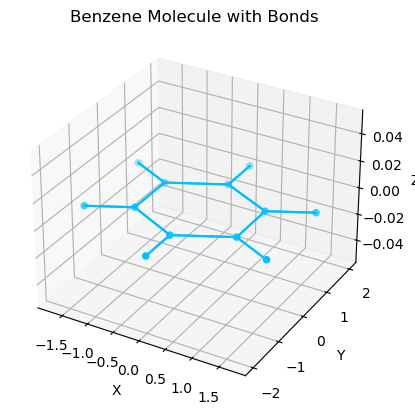

In [4]:
plot_molecules(molecules=[molecule],
               colors=['deepskyblue'],
               labels=[''])

Next, let’s generate a random roto-reflection-translation. We rotate the molecule by a random rotation in 3-space, slide it in a random direction up to a distance of 1, and flip its orientation with probability 50%.

In [5]:
roto_reflection_translation = get_random_roto_reflection_translation()

Random roto-reflection:
	-0.310  0.434 -0.846
	-0.863 -0.502  0.059
	-0.399  0.748  0.530
Random translation:
	 0.0397
	 -0.64
	-0.319


Let’s update our molecule’s atoms’ positions based on this roto-reflection-translation.

In [6]:
transformed_molecule = E3_transform_molecule(molecule, roto_reflection_translation)

Let’s plot their positions in space compared to their original ones.

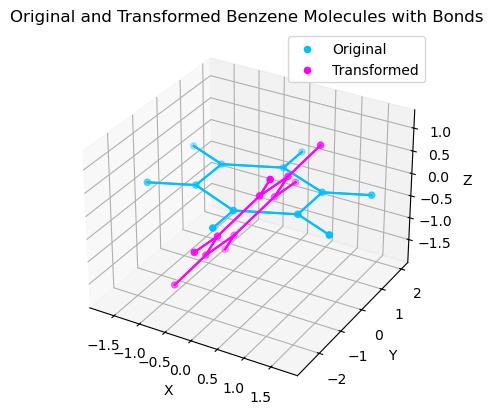

In [7]:
plot_molecules(molecules=[molecule, transformed_molecule], 
               colors=['deepskyblue', 'magenta'], 
               labels=['Original', 'Transformed'],
               title='Original and Transformed Benzene Molecules with Bonds')

This gives some assurance that we have, indeed, acted on our molecule, and that our action is in $E(3)$. We haven’t warped or sheared it, for example.

Let’s see how our model deals with our original and our transformed data.

In [10]:
torch.set_printoptions(threshold=float('inf'))
print('---ORIGINAL---')
transformed_energy_prediction, transformed_force_predictions = model(transformed_molecule)
print('---TRANSFORMED---')
original_energy_prediction, original_force_predictions = model(molecule)

---ORIGINAL---
v0: tensor([[[-0.1095, -0.1095, -0.1095, -0.1095, -0.1095, -0.1095, -0.1095,
          -0.1095, -0.1095, -0.1095, -0.1095, -0.1095, -0.1095, -0.1095,
          -0.1095, -0.1095],
         [ 0.1267,  0.1267,  0.1267,  0.1267,  0.1267,  0.1267,  0.1267,
           0.1267,  0.1267,  0.1267,  0.1267,  0.1267,  0.1267,  0.1267,
           0.1267,  0.1267],
         [-0.1887, -0.1887, -0.1887, -0.1887, -0.1887, -0.1887, -0.1887,
          -0.1887, -0.1887, -0.1887, -0.1887, -0.1887, -0.1887, -0.1887,
          -0.1887, -0.1887]],

        [[ 0.0130,  0.0130,  0.0130,  0.0130,  0.0130,  0.0130,  0.0130,
           0.0130,  0.0130,  0.0130,  0.0130,  0.0130,  0.0130,  0.0130,
           0.0130,  0.0130],
         [ 0.2518,  0.2518,  0.2518,  0.2518,  0.2518,  0.2518,  0.2518,
           0.2518,  0.2518,  0.2518,  0.2518,  0.2518,  0.2518,  0.2518,
           0.2518,  0.2518],
         [-0.0072, -0.0072, -0.0072, -0.0072, -0.0072, -0.0072, -0.0072,
          -0.0072, -0.0072, -0.

We must verify that the model’s energy prediction is invariant to $E(3)$.

In [9]:
print(f'Predicted energy of the original molecule:    {original_energy_prediction.item(): 6.3f}.')
print(f'Predicted energy of the transformed molecule: {transformed_energy_prediction.item(): 6.3f}.')
print(f'Difference:                                   {original_energy_prediction.item() - transformed_energy_prediction.item(): 6.3f}.')
print('\nYou can verify by inspecting each layer of the model that these differences are merely due to the accumulation of floating point discrepancies over many matrix multiplications.')

Predicted energy of the original molecule:     0.324.
Predicted energy of the transformed molecule:  0.321.
Difference:                                    0.002.

You can verify by inspecting each layer of the model that these differences are merely due to the accumulation of floating point discrepancies over many matrix multiplications.


Plotting the force predictions on each atom...

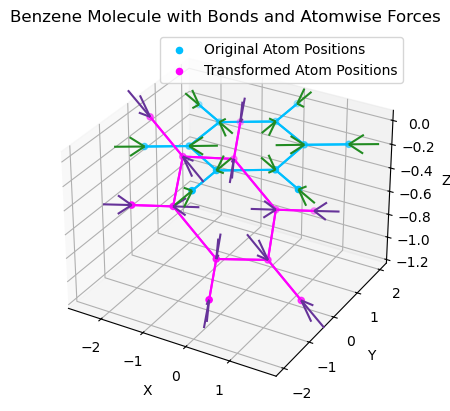

In [11]:
plot_molecules_with_forces(molecules=[molecule, transformed_molecule],
                           forces=[original_force_predictions/3, transformed_force_predictions/3],
                           colors=[['deepskyblue','forestgreen'],['magenta','rebeccapurple']],
                           labels=['Original Atom Positions', 'Transformed Atom Positions'])

The predictions are, of course, different. The molecules are positioned and oriented differently in space.

What we want to guarantee is that if we put the force predictions through the same transformation as the molecule, we get the same result. In other words, $f(g \circ x) = g \circ f(x)$. Let’s transform the force predictions on the original molecule...

In [12]:
transformed_original_force_predictions = E3_transform_force(original_force_predictions, roto_reflection_translation)

... and compare them to the force predictions on the transformed molecule.

In [13]:
print('Force predictions on the tranformed molecule:\nf(g • x) =')
for row in transformed_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')
print('Transformed force predictions on the original molecule:\ng • f(x) =')
for row in transformed_original_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')
print('Differences:')
for row in transformed_force_predictions - transformed_original_force_predictions:
    print(f'\t{row[0].item(): 6.3f} {row[1].item(): 6.3f} {row[2].item(): 6.3f}')

Force predictions on the tranformed molecule:
f(g • x) =
	-0.528  0.060  0.151
	-0.211  0.508  0.093
	 0.329  0.452 -0.059
	 0.528 -0.060 -0.151
	 0.211 -0.508 -0.093
	-0.329 -0.452  0.059
	 0.570 -0.062 -0.159
	 0.218 -0.544 -0.097
	-0.343 -0.480  0.062
	-0.570  0.062  0.159
	-0.218  0.544  0.097
	 0.343  0.480 -0.062
Transformed force predictions on the original molecule:
g • f(x) =
	-0.528  0.059  0.150
	-0.212  0.511  0.094
	 0.329  0.451 -0.060
	 0.528 -0.059 -0.150
	 0.212 -0.511 -0.094
	-0.329 -0.451  0.060
	 0.569 -0.064 -0.162
	 0.218 -0.543 -0.098
	-0.343 -0.481  0.061
	-0.569  0.064  0.162
	-0.218  0.543  0.098
	 0.343  0.481 -0.061
Differences:
	-0.000  0.001  0.001
	 0.000 -0.003 -0.001
	 0.000  0.001  0.001
	 0.000 -0.001 -0.001
	-0.000  0.003  0.001
	-0.000 -0.001 -0.001
	 0.001  0.001  0.003
	-0.000 -0.000  0.001
	-0.000  0.001  0.000
	-0.001 -0.001 -0.003
	 0.000  0.000 -0.001
	 0.000 -0.001 -0.000


Visually, it checks out as well.

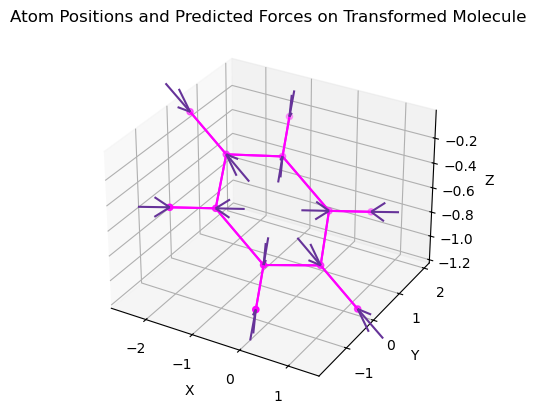

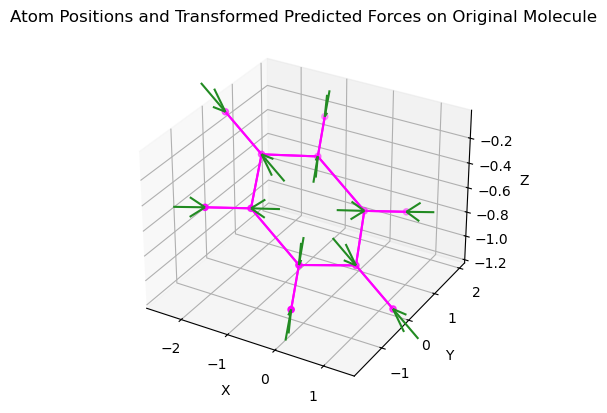

In [15]:
plot_molecules_with_forces(molecules=[transformed_molecule],
                           forces=[transformed_force_predictions/3],
                           colors=[['magenta','rebeccapurple']],
                           labels=[''],
                           title='Atom Positions and Predicted Forces on Transformed Molecule')

plot_molecules_with_forces(molecules=[transformed_molecule],
                           forces=[transformed_original_force_predictions/3],
                           colors=[['magenta','forestgreen']],
                           labels=[''],
                           title='Atom Positions and Transformed Predicted Forces on Original Molecule')

Up to floating point sloppiness, they are the same! Our model is $E(3)$-equivariant, and we reap all the benefits that geometric model design promises.